# Fully Connected Network PoC for 1-D Burgers Equation


## Description: 

The purpose of this notebook is to see if a NN can find the transformation between the input space of $x$ and $t$ to the solution space of $u(x,t)$. This is being done for the 1-D Burgers equation: 

$$
 \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial u^2}{\partial x^2} \:\:\:\: -10 < x < 10, \:\:\:\: 0 < t < 6
$$

With the inital condition of $u(x, 0) = e^{-2x^2}$, $\nu = 0.2$, and homogeneous boundary conditions.


<hr>

<hr>

Imports: 

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import torch 
import torchvision 
from torch import nn
import tqdm
import torch.nn.functional as F 
from matplotlib import pyplot as plt
from math import floor, ceil

import os 
import pandas as pd
from sklearn.model_selection import train_test_split
from zipfile import ZipFile
import glob
from PIL import Image
from torchvision import transforms
from sklearn import preprocessing
import time 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading Data:

In [4]:
# Turn .mat file into dictionary
def add_todict(matobj):
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, sio.matlab.mio5_params.mat_struct):
            dict[strg] = add_todict(elem)
        else:
            dict[strg] = elem
    return dict

def convert_to_dictonary(dict):
    for key in dict:
        if isinstance(dict[key], sio.matlab.mio5_params.mat_struct):
            dict[key] = add_todict(dict[key])
    return dict

data = sio.loadmat('/content/drive/MyDrive/PDE_NNets/Data/Burgers/FC_gaussian_data.mat', struct_as_record=False, squeeze_me=True)
data_dict = convert_to_dictonary(data)

u = data_dict['u'];
x = data_dict['x'];
t = data_dict['t'];

print("u shape:", np.shape(u))
print("x shape:", np.shape(x))
print("t shape:", np.shape(t))

u shape: (201, 201)
x shape: (201,)
t shape: (201,)


### Building Network:

In [44]:
class Network(nn.Module):
  def __init__(self, input_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, 1024)
    self.layer2 = nn.Linear(1024, 2048)
    self.layer3 = nn.Linear(2048, 2048)
    self.layer4 = nn.Linear(2048, 1024)
    self.layer5 = nn.Linear(1024, 512)
    self.layer6 = nn.Linear(512, 256)
    self.layer7 = nn.Linear(256, 1)

  def forward(self, x):
    out = torch.relu(self.layer1(x))
    out = torch.relu(self.layer2(out))
    out = torch.relu(self.layer3(out))
    out = torch.relu(self.layer4(out))
    out = torch.relu(self.layer5(out))
    out = torch.relu(self.layer6(out))

    out = self.layer7(out)

    return out

### Training Function

In [80]:
def train_network(x, t, u, name, half=False):

  print("Training Results for " + str(name) + " Data")
  print("-----------------------------------------")

  # Setting input variables 
  if half == True:
    x = x[::2]
    t = t[::2]
    u = u[:, ::2][::2, :]
    
  U = torch.from_numpy(u).type(torch.Tensor).to(device)
  N = len(x)

  X, T = np.meshgrid(x, t)
  X_train = np.column_stack((X.reshape(N**2, 1), T.reshape(N**2, 1)))
  X_train = torch.from_numpy(X_train).type(torch.Tensor).to(device)


  # Creating Model
  model = Network(2).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
  num_epochs = 500
  loss_fn = torch.nn.MSELoss()


  # Training 
  losses = []
  for epoch in range(num_epochs):
    u_pred = model(X_train).to(device)
    loss = loss_fn(u_pred.reshape(N, N), U)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if epoch % 50 == 0:
      print("Epoch:", epoch, "    Loss:", loss.item())

  print("\nFinal Training Loss:", loss.item(),"\n")

  # Plotting training loss 
  plt.plot(losses, label="Training loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.title("Training Loss for" + str(name) + " Data")
  plt.show()


  # Plotting Predicted vs. True Solution 
  xspan, tspan = np.meshgrid(x, t)
  u_true = u
  fig = plt.figure(figsize=(14, 8))


  # True solution plot 
  ax = fig.add_subplot(1, 2, 1, projection='3d')
  ax.plot_surface(xspan, tspan, u_true.T, cmap='plasma')
  ax.set_xlabel('x')
  ax.set_ylabel('t')
  ax.set_zlabel('u(x,t)')
  ax.set_title(str(name) + " Data True Solution\n\n")


  # Predicted solution plot 
  Upred = u_pred.detach().cpu().numpy().reshape(N, N)
  ax = fig.add_subplot(1, 2, 2, projection='3d')
  ax.plot_surface(xspan, tspan, Upred.T, cmap='plasma')
  ax.set_xlabel('x')
  ax.set_ylabel('t')
  ax.set_zlabel('u(x,t)')
  ax.set_zticks(np.linspace(0, 1, 6))
  ax.set_title(str(name) + " Data Predicted Solution\n\n")

  plt.show()

### Training for Half Data

Training Results for Half Data
-----------------------------------------
Epoch: 0     Loss: 0.019225768744945526
Epoch: 50     Loss: 0.011635664850473404
Epoch: 100     Loss: 0.010103209875524044
Epoch: 150     Loss: 0.0075764949433505535
Epoch: 200     Loss: 0.004492966458201408
Epoch: 250     Loss: 0.002161981537938118
Epoch: 300     Loss: 0.001086804666556418
Epoch: 350     Loss: 0.0006664667162112892
Epoch: 400     Loss: 0.0004404284118209034
Epoch: 450     Loss: 0.00033699703635647893

Final Training Loss: 0.00025006147916428745 



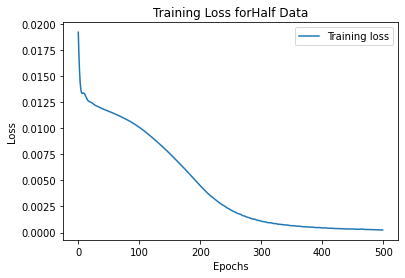

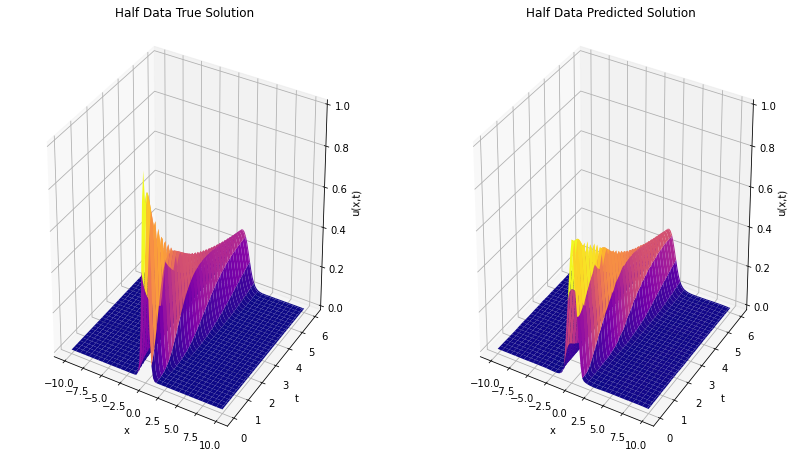

In [81]:
train_network(x, t, u, "Half", True)

### Training for Full Data

Training Results for Full Data
-----------------------------------------
Epoch: 0     Loss: 0.017391415312886238
Epoch: 50     Loss: 0.011360200121998787
Epoch: 100     Loss: 0.009715905413031578
Epoch: 150     Loss: 0.007148087956011295
Epoch: 200     Loss: 0.004362700041383505
Epoch: 250     Loss: 0.0021514177788048983
Epoch: 300     Loss: 0.0009947490179911256
Epoch: 350     Loss: 0.000577040365897119
Epoch: 400     Loss: 0.00038058828795328736
Epoch: 450     Loss: 0.00026838158373720944

Final Training Loss: 0.0002069893089355901 



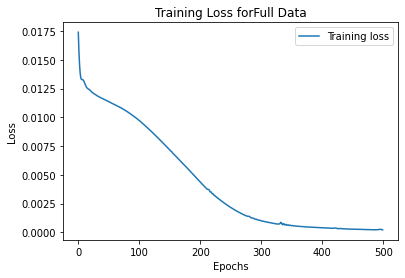

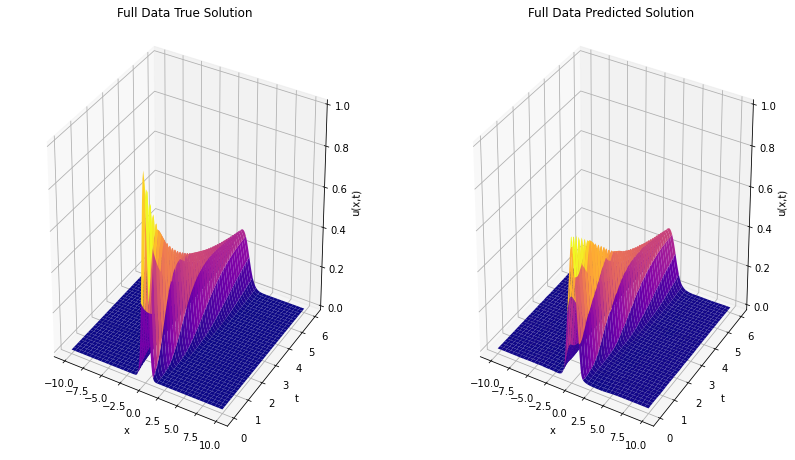

In [82]:
train_network(x, t, u, "Full", False)